# Waveguide Bend Optimization

In this tutorial, we'll examine how we can use Meep's adjoint solver to optimize for a particular design criteria. Specifcally, we'll maximize the transmission around a silicon waveguide bend. This tutorial will illustrate the adjoint solver's ability to quickly calculate gradients for objective functions with multiple objective quantities.

To begin, we'll import meep, our adjoint module, `autograd` (as before) and we will also import `nlopt`, a nonlinear optimization package.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
import nlopt
from matplotlib import pyplot as plt
mp.quiet(quietval=True)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

Using MPI version 3.1, 1 processes


Next, we'll build a 90 degree bend waveguide with a design region that is 1 micron by 1 micron. We'll discretize our region into a 10 x 10 grid (100 total parameters). We'll send in a narrowband gaussian pulse centered at 1550 nm. We'll also use the same objective function and optimizer object as before.

In [2]:
resolution = 10

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1.5,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

design_region_resolution = 10
Nx = design_region_resolution
Ny = design_region_resolution

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si,grid_type='U_SUM')
design_region = mpa.DesignRegion(design_variables,volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0)))


geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=Si, size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=Si, size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables), # design region
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
             e1=mp.Vector3(x=-1).rotate(mp.Vector3(z=1), np.pi/2), e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), np.pi/2))
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)

TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(x=2)),mode=1)
ob_list = [TE_top]

def J(alpha):
    return npa.abs(alpha) ** 2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ez]
)

As before, we'll visualize everything to ensure our monitors, boundary layers, and geometry are drawn correctly.

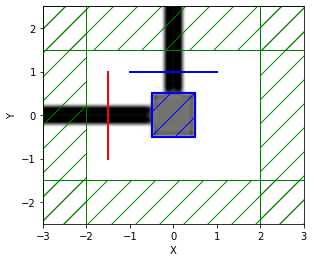

In [3]:
x0 = 0.5*np.ones((Nx*Ny,))
opt.update_design([x0])

opt.plot2D(True)
plt.show()

We can now define a cost function wrapper that we can feed into our `nlopt` optimizer. `nlopt` expects a python function where the gradient is passed in place. In addition, we'll update a list with every objective function call so we can track the cost function evolution each iteration.

Notice the `opt` adjoint solver object requires we pass our numpy array of design parameters within an additional list. This is because the adjoint solver can solve for multiple design regions simultaneously. It's useful to break up each region's parameters into indvidual numpy arrays. In this simple example, we only have one design region.

In [4]:
evaluation_history = []
sensitivity = [0]
def f(x, grad):
    f0, dJ_du = opt([x])
    if grad.size > 0:
        grad[:] = np.squeeze(dJ_du)
    evaluation_history.append(np.real(f0))
    sensitivity[0] = dJ_du
    return np.real(f0)

Now we can set up the actual optimizer engine. We'll select the Method of Moving Asymptotes because it's a gradient based method that allows us to specify linear and nonlinear constraints. For now, we'll simply bound our parameters between 0 and 1.

We'll tell our solver to maximize (rather than minimize) our cost function, since we are trying to maximize the power transmission around the bend.

We'll also tell the optimizer to stop after 10 function calls. This will keep the wait time short and demonstrate how powerful the adjoint solver is.

In [5]:
algorithm = nlopt.LD_MMA
n = Nx * Ny
maxeval = 10

solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(0)
solver.set_upper_bounds(1)
solver.set_max_objective(f)
solver.set_maxeval(maxeval)
x = solver.optimize(x0);

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward 

Now that the solver is done running, we can evaluate our progress.

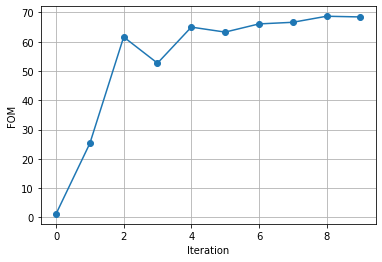

In [6]:
plt.figure()
plt.plot(evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('FOM')
plt.show()

We can update our optimization object and visualize the results.

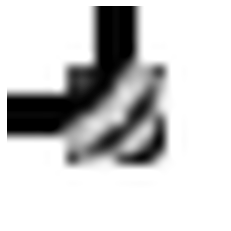

In [7]:
opt.update_design([x])
opt.plot2D(True,plot_monitors_flag=False,output_plane=mp.Volume(center=(0,0,0),size=(2,2,0)))
plt.axis("off");

We quickly see that the solver improves the design each iteration, but because of the way we chose to formulate our cost function, it's difficult to quantify our results. After all, how good is a figure of merit (FOM) of 70?

To overcome this, we'll slightly modify our objective function to include an extra monitor just after the source. This monitor will track however much power is transmitted into the waveguide. We can then normalize the upper monitor's response by this parameter:

In [8]:
TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(-1,0,0),size=mp.Vector3(y=2)),mode=1)
ob_list = [TE0,TE_top]

def J(source,top):
    return npa.abs(top/source) ** 2

opt.objective_functions = [J]
opt.objective_arguments = ob_list
opt.update_design([x0])

We'll refresh our solver and try optimizing again:

In [9]:
evaluation_history = []
solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(0)
solver.set_upper_bounds(1)
solver.set_max_objective(f)
solver.set_maxeval(maxeval)
x = solver.optimize(x0)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward 

We can view our results and normalize the FOM as the percent power transmission.

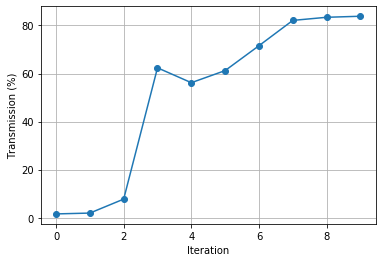

In [10]:
plt.figure()
plt.plot(np.array(evaluation_history)*100,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Transmission (%)')
plt.show()

We once again clearly see great improvement, from about 5% transmission to about 75%, after just 10 iterations! We noticed that the cost function is much more complicated now as the optimizer no longer monotonically improves as it did before.

In [11]:
improvement = max(evaluation_history) / min(evaluation_history)
print("Achieved an improvement of {0:1.1f}x".format(improvement))

Achieved an improvement of 53.1x


Finally, we can visualize our new geometry. We see that the design region naturally connected the two waveguide segements in a bend fashion and has placed several other distinctive features around the curve.

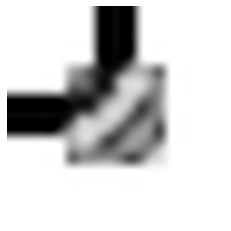

In [12]:
opt.update_design([x])
opt.plot2D(True,plot_monitors_flag=False,output_plane=mp.Volume(center=(0,0,0),size=(2,2,0)))
plt.axis("off");

We can also visualize the sensitivity to see which geometric areas are most sensitive to perturbations.

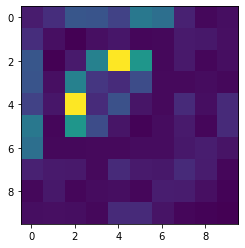

In [13]:
plt.imshow(np.rot90(np.squeeze(np.abs(sensitivity[0].reshape(Nx,Ny)))));